In [1]:
import os
import sys
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)


from utilities.kernels import *
from gp.Darcyflow_DTO import Darcyflow
from utilities.domains import *

import jax.numpy as jnp
from jax import grad, vmap
import jax

jax.config.update("jax_enable_x64", True)

import numpy as np
import munch

from scipy.interpolate import griddata
from gp.Darcyflow_FD import FD_Darcy_flow_2d

# visulization: plot figures
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

cfg = munch.munchify({
    'M' : 500,
    'M_Omega' : 400,
    'valid_M': 500,
    'valid_M_Omega': 400,
    'learning_epoch': 100,
    'learning_tol': 1e-5,
    'ls_u' : 1.0,
    'ls_a' : 1.0,
    # 'ls_pts': 10, # The number of points on grid [1e-2, 1] for linear searching
    'N_data': 60,
    'noise_level': 1e-3,
    'u_nugget': 1e-5,
    'a_nugget': 1e-5,
    'epoch': 30,
    'batch_size': 60,
    'learning_rate': 1e-2,
    'tol' : 10 ** (-5),
    'verbose': True,
    'plot': True,
})

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 26

plt.rcParams['axes.labelpad'] = 10
#plt.rcParams["figure.figsize"] = (8, 6)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=21)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###############get the observed data
N_pts_per_dim = 80  # solve the equation using classical methods on a grid, interpolate to get the observed data
xx = np.linspace(0, 1, N_pts_per_dim)
yy = np.linspace(0, 1, N_pts_per_dim)
XX, YY = np.meshgrid(xx, yy)
XXv = np.array(XX.flatten())
YYv = np.array(YY.flatten())

def a(x1, x2):  # a(x) truth
    c = 1
    return jnp.exp(c * jnp.sin(2 * jnp.pi * x1) + c * jnp.sin(2 * jnp.pi * x2)) + jnp.exp(
        -c * jnp.sin(2 * jnp.pi * x1) - c * jnp.sin(2 * jnp.pi * x2))

def f(x1, x2):
    return 1

u_truth_grid = FD_Darcy_flow_2d(N_pts_per_dim - 2, a, f)
u_truth_grid_vec = np.reshape(u_truth_grid, (-1, 1))

def get_data_u(x, y):
    return griddata((XXv, YYv), u_truth_grid_vec, (x, y), method='linear')


#np.random.seed(0)

domain = Square(0, 1, 0, 1)
# kernel = Gaussian_Kernel(cfg.lenghscale)
kernel_u_generator = lambda ls_u: Gaussian_Kernel(ls_u)
kernel_a_generator = lambda ls_a: Gaussian_Kernel(ls_a)

eq = Darcyflow(kernel_u_generator, kernel_u_generator, domain)

eq.sampling(cfg)

data_u = np.vectorize(get_data_u)(eq.X_data[:, 0], eq.X_data[:, 1])
eq.get_observation(data_u, cfg.noise_level)

u_func, a_func = eq.trainGN(cfg)

##### step5: GP interpolation and test accuracy
X_test = jnp.concatenate((XX.reshape(-1, 1), YY.reshape(-1, 1)), axis=1)
test_u = vmap(u_func)(X_test)
test_a = vmap(a_func)(X_test)

test_u = np.reshape(test_u, (N_pts_per_dim, N_pts_per_dim))
test_a = np.reshape(test_a, (N_pts_per_dim, N_pts_per_dim))

test_truth_u = u_truth_grid
test_truth_a = np.reshape(vmap(a)(X_test[:, 0], X_test[:, 1]), (N_pts_per_dim, N_pts_per_dim))

u_error = np.abs(test_truth_u - test_u)

/Users/yangx0e/Documents/Paper/BilevelHyperparameterLearning/gp/Darcyflow_FD.py:28: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  sol_u = scipy.sparse.linalg.spsolve(A, fv)


        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 0, Current Loss 1.021303515716542, param u 0.9990000000593129, param a 0.9990000002188975
        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 1, Current Loss 1.0210894783005486, param u 0.9980000997223751, param a 0.9979999188502926
        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 2, Current Loss 1.0208759382374815, param u 0.9970003648511728, param a 0.9969997017418663
        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 3, Current Loss 1.0206628992303746, param u 0.9960008606643656, param a 0.9959992951011416
        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 4, Current Loss 1.0204503656673003, param u 0.9950016515497362, param a 0.9949986456370159
        Learning Hyperparameters, GN Epoch 0, Learning Hyper Epoch 5, Current Loss 1.0202383402354123, param u 0.9940028008806914, param a 0.9939977006971288
        Learning Hyperparameters, GN Epoch 0, Learnin

2025-10-08 01:16:28.344198: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %dot.1496 = f64[2400,2400]{1,0} dot(%constant.170, %constant.67), lhs_contracting_dims={1}, rhs_contracting_dims={0}, metadata={op_name="jit(solve_pde)/jit(main)/dot_general" source_file="/Users/yangx0e/Documents/Paper/BilevelHyperparameterLearning/gp/Darcyflow_DTO.py" source_line=522}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-08 01:16:28.403102: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.079299s
Constant folding an instruction is taking > 1s:

  %dot.1496 = f6

Epoch 10, param u 0.24371887947222454, param a 0.1379841346254664, PDE error 110.35764283507231
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 0, Current Loss 0.4401592234692242, param u 0.24271887955178165, param a 0.13898412479818234
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 1, Current Loss 0.4400451191469903, param u 0.24171876359250305, param a 0.13826825669789947
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 2, Current Loss 0.4399112269156733, param u 0.24071977302040914, param a 0.13766801622447541
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 3, Current Loss 0.4397954253449936, param u 0.23972263671548139, param a 0.13760977974955563
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 4, Current Loss 0.4396790282224488, param u 0.23872738766489088, param a 0.1378917056316706
        Learning Hyperparameters, GN Epoch 10, Learning Hyper Epoch 5, Current Loss 0.43955775231145

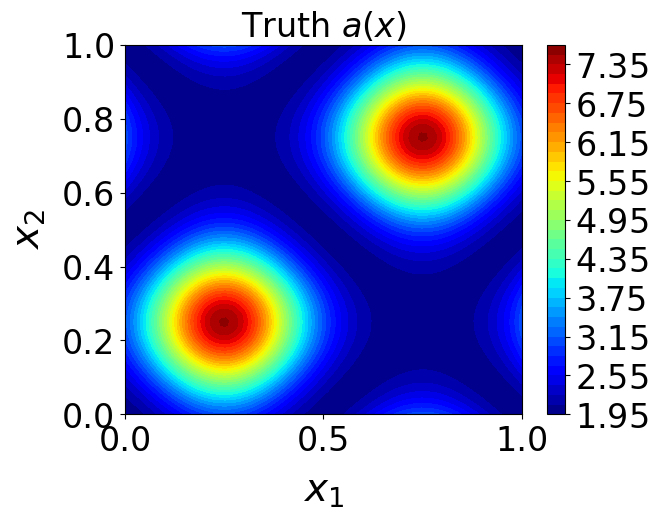

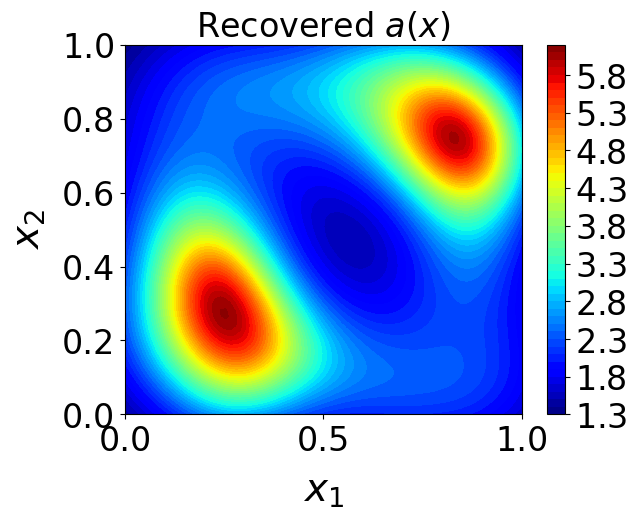

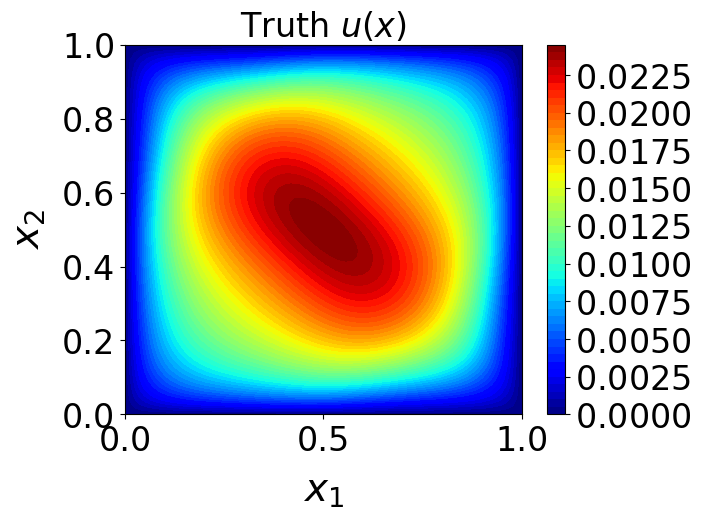

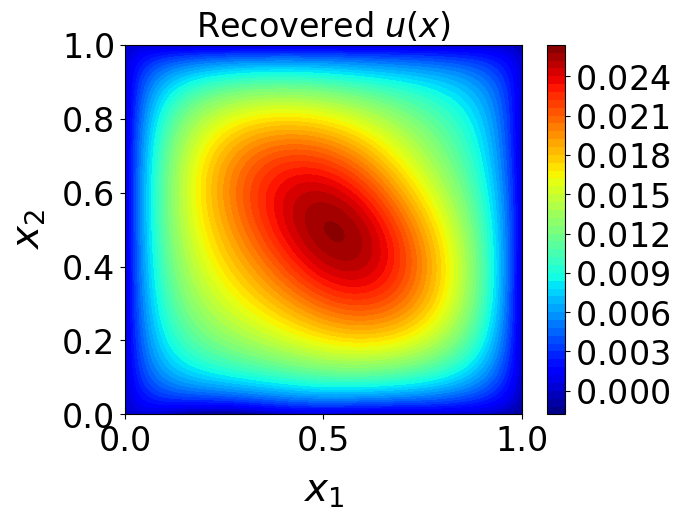

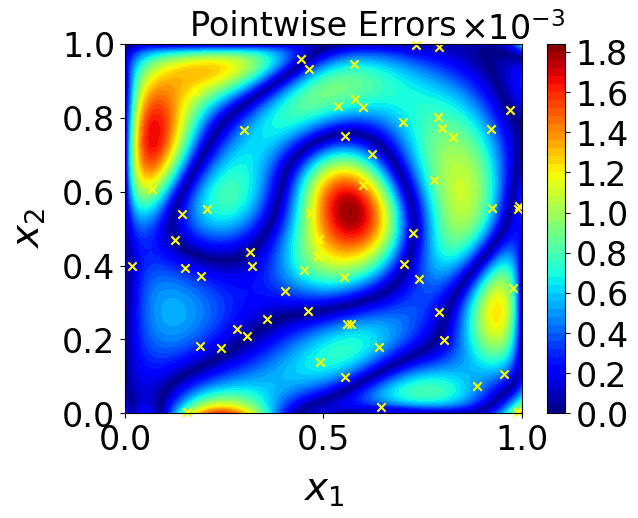

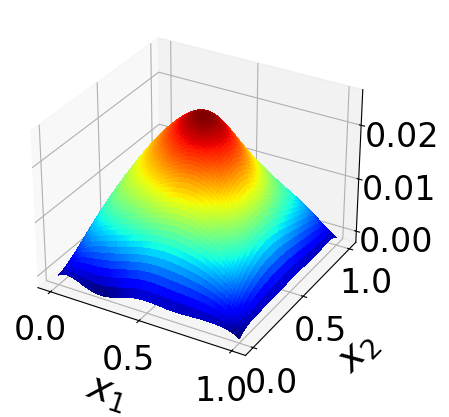

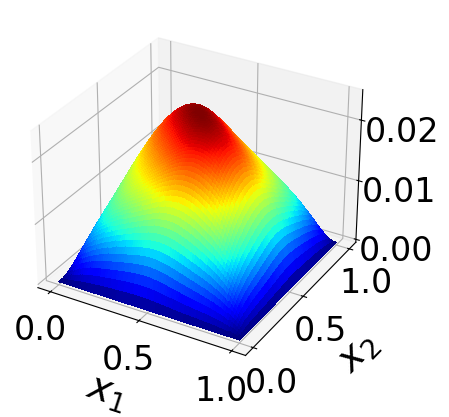

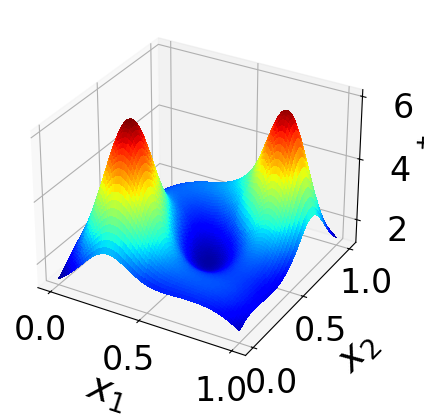

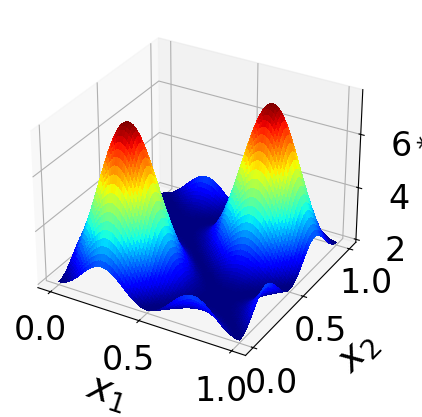

In [2]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp

# … other imports …

if cfg.plot:
    #── specify and create the figures folder ───────────────────────────────────
    figures_dir = "./figures"
    os.makedirs(figures_dir, exist_ok=True)

    #── 2D contour plots ────────────────────────────────────────────────────────

    # Truth a(x)
    fig, ax = plt.subplots()
    cf = ax.contourf(XX, YY, test_truth_a, 50, cmap=plt.cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Truth $a(x)$')
    fig.colorbar(cf, format=fmt)
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_a_ref_contour.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
    )

    # Recovered a(x)
    fig, ax = plt.subplots()
    cf = ax.contourf(XX, YY, jnp.exp(test_a), 50, cmap=plt.cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Recovered $a(x)$')
    fig.colorbar(cf, format=fmt)
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_a_pred_contour.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
    )

    # Truth u(x)
    fig, ax = plt.subplots()
    cf = ax.contourf(XX, YY, test_truth_u, 50, cmap=plt.cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Truth $u(x)$')
    fig.colorbar(cf, format=fmt)
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_u_ref_contour.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
    )

    # Recovered u(x)
    fig, ax = plt.subplots()
    cf = ax.contourf(XX, YY, test_u, 50, cmap=plt.cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Recovered $u(x)$')
    fig.colorbar(cf, format=fmt)
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_u_pred_contour.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
    )

    # Pointwise errors
    fig, ax = plt.subplots()
    cf = ax.contourf(XX, YY, u_error, 50, cmap=plt.cm.jet)
    ax.scatter(
        eq.X_data[:, 0],
        eq.X_data[:, 1],
        marker="x",
        c="yellow",
        clip_on=False,
    )
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Pointwise Errors')
    fig.colorbar(cf, format=fmt)
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_u_err.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
    )

    #── 3D surface plots ─────────────────────────────────────────────────────────

    # Predicted u
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(
        XX, YY, test_u,
        rstride=1, cstride=1,
        cmap=plt.cm.jet,
        linewidth=0,
        antialiased=False
    )
    ax.set_xlabel(r'$x_1$', labelpad=15)
    ax.set_ylabel(r'$x_2$', labelpad=15)
    ax.set_zlabel(r'$u^\dagger$', labelpad=30)
    ax.tick_params(axis='z', which='major', pad=10)
    zlbl = ax.zaxis.label
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_u_pred.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
        bbox_extra_artists=[zlbl],
    )

    # Reference u
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(
        XX, YY, test_truth_u,
        rstride=1, cstride=1,
        cmap=plt.cm.jet,
        linewidth=0,
        antialiased=False
    )
    ax.set_xlabel(r'$x_1$', labelpad=15)
    ax.set_ylabel(r'$x_2$', labelpad=15)
    ax.set_zlabel(r'$u^*$', labelpad=30)
    ax.tick_params(axis='z', which='major', pad=10)
    zlbl = ax.zaxis.label
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_u_ref.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
        bbox_extra_artists=[zlbl],
    )

    # Predicted a
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(
        XX, YY, jnp.exp(test_a),
        rstride=1, cstride=1,
        cmap=plt.cm.jet,
        linewidth=0,
        antialiased=False
    )
    ax.set_xlabel(r'$x_1$', labelpad=15)
    ax.set_ylabel(r'$x_2$', labelpad=15)
    ax.set_zlabel(r'$a^\dagger$', labelpad=15)
    ax.tick_params(axis='z', which='major', pad=10)
    zlbl = ax.zaxis.label
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_a_pred.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
        bbox_extra_artists=[zlbl],
    )

    # Reference a
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(
        XX, YY, test_truth_a,
        rstride=1, cstride=1,
        cmap=plt.cm.jet,
        linewidth=0,
        antialiased=False
    )
    ax.set_xlabel(r'$x_1$', labelpad=15)
    ax.set_ylabel(r'$x_2$', labelpad=15)
    ax.set_zlabel(r'$a^*$', labelpad=15)
    ax.tick_params(axis='z', which='major', pad=10)
    zlbl = ax.zaxis.label
    fig.savefig(
        os.path.join(figures_dir, "darcyflow_v2_new_a_ref.png"),
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.1,
        bbox_extra_artists=[zlbl],
    )

    plt.show()